In [1]:
from Uncertainty import *
from uncertaintyMetric import *
from utils import *

K.clear_session()
check_tensorflow_gpu()

Checking Tensorflow Version:
Tensorflow built with CUDA? True
Tensorflow version: 2.6.2
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# select       = 7
# plot_bounds  = [-3, 3]

# local_method = 'trust-krylov'
# x0           = [1.5, 1.5]
# glob_bounds  = [-2, 2]

# opt = FullOpt(select)
# local_res,  local_res_df  = opt.local_opt(x0=x0, method=local_method)
# global_res, global_res_df = opt.global_opt(varbounds=glob_bounds)
# opt.make_plot(global_res_df, local_res_df, mbounds=plot_bounds, showcontours=True, showtrajectory=True, angle=[45,225])

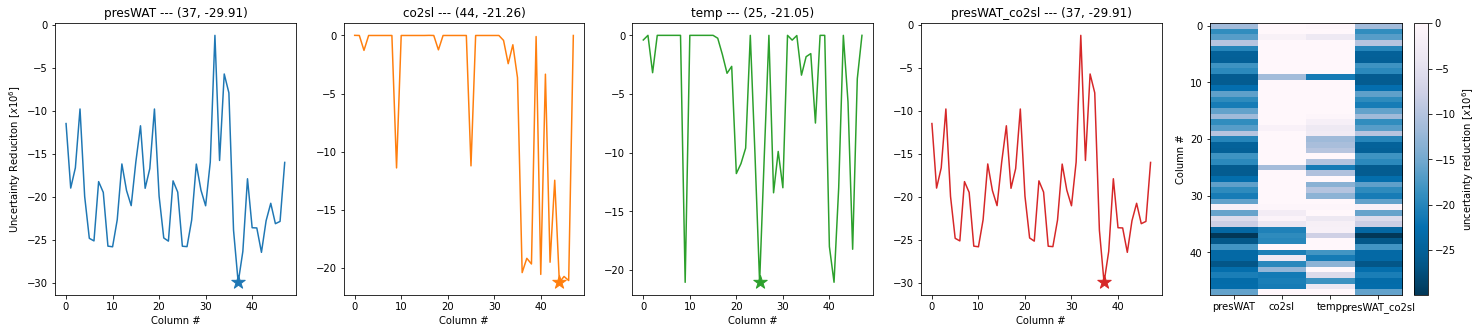

In [75]:
result_presWAT = np.load('result_presWAT.npy')
result_co2sl   = np.load('result_co2sl.npy')
result_temp    = np.load('result_temp.npy')
result_presWAT_co2sl = np.load('result_presWAT_co2sl.npy')
results = [result_presWAT, result_co2sl, result_temp, result_presWAT_co2sl]
titles  = ['presWAT','co2sl','temp','presWAT_co2sl']

temp = np.zeros((48,4))
for i in range(4):
    temp[:,i] = results[i]
    
plt.figure(figsize=(25,5))
for i in range(len(results)):
    minloc, minval = np.argmin(results[i]), np.min(results[i])
    plt.subplot(1,5,i+1)
    plt.plot(results[i], c='C{}'.format(i))
    plt.scatter(minloc, minval, c='C{}'.format(i), marker='*', s=200)
    plt.title('{} --- ({}, {:.2f})'.format(titles[i], minloc, minval))
    plt.xlabel('Column #')
    if i==0:
        plt.ylabel('Uncertainty Reduciton [$x10^6$]')

plt.subplot(1,5,5)
plt.imshow(temp, aspect='auto', cmap='PuBu_r')
plt.xticks(np.arange(4), labels=titles)
plt.ylabel('Column #')
plt.colorbar(label='uncertainty reduction [$x10^6$]')
plt.show()

***
By Layer

In [ ]:
opt = FullOpt(select=0, dims=1)
global_res, global_res_df = opt.global_opt(varbounds   = [1,16], 
                                           vartype     = 'int', 
                                           maxiter     = 20, 
                                           pop_size    = 4, 
                                           parent_prop = 0.25,
                                           elitratio   = 0,
                                           maxiter_no_improv = 3)

In [ ]:
opt = FullOpt(select=0, dims=1)
global_res, global_res_df = opt.global_opt(varbounds   = [16,32], 
                                           vartype     = 'int', 
                                           maxiter     = 20, 
                                           pop_size    = 4, 
                                           parent_prop = 0.25,
                                           elitratio   = 0,
                                           maxiter_no_improv = 3)

In [ ]:
opt = FullOpt(select=0, dims=1)
global_res, global_res_df = opt.global_opt(varbounds   = [32,48], 
                                           vartype     = 'int', 
                                           maxiter     = 20, 
                                           pop_size    = 4, 
                                           parent_prop = 0.25,
                                           elitratio   = 0,
                                           maxiter_no_improv = 3)

***

In [ ]:
# General settings
Main_Directory   = os.getcwd()
Data_Directory   = os.path.join(Main_Directory, 'data')
titles           = ['.', 'Pressure', 'CO2 Saturation (l)', 'Temperature', 'Pressure + CO2 Saturation']
unc_params       = ['perm4', 'perm5', 'perm6', 'kmult']

MeasureType      = 1                           # Measurement type: 1 for pressure; 2 for CO2 saturation; 3 for tempeture, 4 for pressure+CO2 saturation                     
Total_time       = 1800                        # Total injection and post-injection time (days)
nTimeSeries      = 60                          # The number of measurement time series
nInterval        = 1                           # Measurement interval, default value = 1/Month

nTrain           = 500                         # The number of training simulations
Obj_filename     = 'run_co2mt.his'             # Objective file name
nColumn_obj      = 50                          # The column(s) in which the object of interest is located
nColumn_data     = [7]    #[7]                 # The column in which the data measurement is located 

x_max            = [1e-14, 1e-14, 1e-14, 2.0]  # Upper bounds for all the uncertain parameters
x_min            = [1e-19, 1e-19, 1e-19, 0.5]  # Lower bounds for all the uncertain parameters
ROMs_validation  = 0                           # ROMs cross-validation flag
nMCSamples       = 10000  #100000              # Number of monte carlo samples
nParam           = 4                           # Number of uncertain parameters
nDataRealization = 100    #200                 # Number of data realizations
err_option       = 3                           # Type of err option (2=MeanAE, 3=MaxAE)
time_sensitivity = 1                           # Whether consider time sensitivity for UR flag
post_processing  = 1                           # Plotting flag
print('Current Working Directory: {}'.format(Main_Directory))
print('Data Directory: {}'.format(Data_Directory))

## Step 1: Perfrom training simulation
# This step is done in a seperate code.

roms = [Ridge(), Ridge()]

In [ ]:
## Step 2: Read-in training simulation results
training_data, raw_data, parameters = read_train_sim_results(Data_Directory, MeasureType, Obj_filename, nColumn_obj, Total_time, nTimeSeries,
                                                                nColumn_data, nInterval, nTrain, nParam, x_min, x_max, titles)
#unpack variables
data_train, x_train, x_train_scaled, y_train, y_train_scaled = training_data
data_train_read_raw, data_train_read_raw0                    = raw_data
eps, nData, time_point                                       = parameters

plot_train_data(data_train, x_train_scaled, y_train_scaled, titles, MeasureType, Obj_filename, unc_params)

In [ ]:
## Step 3: 10-fold cross-validation of ROMs (iff ROMS_validation=1)
## Step 4: Construct the Mars ROMs for data and response of interest
ROM_data, ROM_obj = rom_validation(ROMs_validation, Ridge(), Ridge(), x_train_scaled, y_train, data_train, nTrain, nData, data_train_read_raw, NN=False)

In [ ]:
## Step 5: Generate Monte Carlo(MC) samples
np.random.seed(787878)
mc_design = np.random.rand(nMCSamples, nParam)
mc_design = mc_design*2 - 1
print('Generate Monte Carlo samples: Done!')

## Step 6: Evaluate the MC samples using the built ROMs for data points/objs
mc_data, mc_obj = evaluate_MC_with_ROM(ROM_data, ROM_obj, data_train_read_raw, mc_design, nData, nMCSamples)

In [ ]:
## Step 7: Calculate posterior distribution and uncertainty reduction
prior_mean, prior_p90mp10, synthetic_data, results = uncertainty_reduction(mc_obj, mc_data, ROM_data, data_train_read_raw, MeasureType,
                                                                            nData, nDataRealization, nParam, nColumn_data, 
                                                                            x_min, x_max, eps, err_option, time_sensitivity)

post_p90mp10_mean, post_p90mp10_time, post_p90mp10_iData, post_mean, post_mean_iData, nSamples, mc_obj_post = results

In [ ]:
## Step 8: Post-processing
make_post_processing(post_processing, results, synthetic_data, mc_obj, prior_p90mp10, data_train_read_raw0, time_point, Total_time, nDataRealization, nMCSamples, nColumn_data, nTimeSeries)

***
# END